In [12]:
from skykatana import SkyMaskPipe
import matplotlib.pyplot as plt
from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord
import lsdb          # if pixelating source catalogs in HATS format

Excecute the cell below to inject some styles used thougout this notebook

In [13]:
%%html
<style>
/* Light theme */
body[data-jp-theme-light="true"] .met   { background-color: rgb(218, 229, 251);  color: rgb(27, 58, 121); padding:3px 3px; border:1px solid rgb(36, 138, 255);  border-radius:6px; }
body[data-jp-theme-light="true"] .icode { font-family: monospace; color: rgb(91, 151, 43); }
body[data-jp-theme-light="true"] .sc    { font-variant: small-caps; font-weight: bold; }
body[data-jp-theme-light="true"] .note  { display:inline-block; background-color: rgb(91, 144, 251); color:white; padding:6px; border-radius:6px; font-size:1em; }
body[data-jp-theme-light="true"] .callout { border-left:6px solid rgb(99,99,99); border-right:6px solid rgb(99,99,99); border-radius:6px;
                                            background: rgb(255, 255, 255); padding:8px 16px; font-size:1em; }
body[data-jp-theme-light="true"] .st    { color: rgb(162, 93, 93); padding:0 8px; font-weight:bold; border-radius:12px; border:1px solid rgb(247,94,94); }
/* Dark theme */
body[data-jp-theme-light="false"] .met   { background-color: rgb(39,51,61);  color: rgb(222,219,142); padding:3px 3px; border:1px solid rgb(78,115,128); border-radius:6px; }
body[data-jp-theme-light="false"] .icode { font-family: monospace; color: rgb(145,208,93); }
body[data-jp-theme-light="false"] .sc    { font-variant: small-caps; font-weight: bold; }
body[data-jp-theme-light="false"] .note  { display:inline-block; background-color: rgb(23,80,130); color:white; padding:6px; border-radius:6px; font-size:1em; }
body[data-jp-theme-light="false"] .callout { border-left:6px solid rgb(99,99,99); border-right:6px solid rgb(99,99,99); border-radius:6px;
                                             background: rgba(40,40,40,0.8); padding:8px 16px; font-size:1em; color: rgb(181, 181, 181);}
body[data-jp-theme-light="false"] .st    { color: rgb(255,255,255); padding:0 8px; font-weight:bold; border-radius:12px; border:1px solid rgb(247,94,94); }
</style>

# Quick intro or how to swing a Skykatana
-----------------
Starting from an input catalog of sources, a list of geometric shapes, or any healsparse map, <span class="sc">Skykatana</span> can create a pixelized mask in healsparse format, excluding areas due to various effects such as bright stars, patches with low depth, extended sources, etc. <span class="sc">Skykatana</span> is also designed to create star masks on-demand in the Rubin Science Platform over thousands of deg<sup>2</sup> in just a few minutes with very limited memory resources, and even intersect masks from different surveys.

Basic usage: 
* <span class="met">build_foot_mask(), build_patch_mask(), build_circle_mask()</span>, etc. are used to produce individual masks <div style="height:0.5em;"></div>
* <span class="met">combine()</span> to merge the maps create above into a "final" mask <div style="height:0.5em;"></div>
* <span class="met">plot()</span> can quickly visualize a mask by plotting randoms, make zooms and overplot stars <div style="height:0.5em;"></div>
* <span class="met">plot_moc</span> to visualize a MOC version of a mask, with accurrate coordinate projections <div style="height:0.5em;"></div>
* <span class="met">makerans</span> to generate randoms over any mask <div style="height:0.5em;"></div>
* <span class="met">apply</span> to cut out sources outside of any given mask

When pixelating an input catalog of sources, <span class="sc">Skykatana</span>  accepts a pandas daframe, any data format readable by astropy, or a HATS catalog. In the latter case, pixelization can be distributed across workers to handle catalogs larger than available memory, such as Rubin.

For creating bright star masks, <span class="sc">Skykatana</span> has special methods to query and pixelate large online catalogs in HATS format (such as Gaia), that work in systems with limited memory resources.

Masks and their metadata are stored as **stages** in a **pipeline** class object that can be saved to disk
<br>
<div class="note">This notebook shows how to produce a mask for a region of the Subaru Hyper Suprime-Cam Subaru Strategic Program survey (HSC-SSP)</div>

## Example dataset

We have prepared a [small dataset](https://drive.google.com/file/d/1Fft9E9uD1eXs-8Dxb8bp5ou1bEtCTkgr/view?usp=sharing) (alternatively at https://tinyurl.com/dataHSC). It consists of ~8 million HSC galaxies stored as a HATS catalog and the auxiliary input files used below. Download (170 MB), decompress it, and then adjust the folder location in `BASEPATH` below.

## Define inputs

In [14]:
# Adjust this path if needed
BASEPATH = Path('./example_data/')

# Input HATS catalog (these are HSC galaxies)
HATSCAT = BASEPATH / 'hscx_minispring_gal/'

# Bright stars in HSC area
STARS_REGIONS     = BASEPATH / 'hsc_aux/stars_iband.parquet'
# Boxes around stars in HSC
BOX_STARS_REGIONS = BASEPATH / 'hsc_aux/starboxes_iband.parquet' 

# HSC patches and QA patch list ###################################### 
# See https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_wide.patch_qa
PATCH_FILE     = [BASEPATH / 'hsc_aux/tracts_patches_minispring.parquet']
QA_FILE        = BASEPATH / 'hsc_aux/patch_qa.csv'

# SFD dust extintion map (cut to the region covered in this example)
PROPMAP_FILE   = BASEPATH / 'hsc_aux/sfd_ebv_piece.fits'

# Some dummy geometrical regions
ELLIP_REGIONS       = BASEPATH / 'hsc_aux/extended_sources.dat'
USER_CIRCLE_REGIONS = BASEPATH / 'hsc_aux/user_circs.dat' 
USER_POLY_REGIONS   = BASEPATH / 'hsc_aux/user_polys.dat'
USER_ZONE_REGIONS   = BASEPATH / 'hsc_aux/user_zones.dat'

## Explore dataset

<div class="callout"> The catalog has 11 partitions. Let's explore the catalog and visualize partitions on the sky.
</div>

In [15]:
sources=lsdb.open_catalog(HATSCAT)
print(f'Number of partitions: {sources.npartitions}')

Number of partitions: 11


In [16]:
sources

Dask NestedFrame Structure:
                                  ra              dec
npartitions=11                                       
576460752303423488   double[pyarrow]  double[pyarrow]
578712552117108736               ...              ...
...                              ...              ...
3169408237761986560              ...              ...
3170534137668829184              ...              ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

In [17]:
sources.hc_structure.catalog_info

catalog_name   hscx_minispring_gal
catalog_type   object
total_rows     8459347
ra_column      ra
dec_column     dec
healpix_column _healpix_29
healpix_order  29
npix_suffix    .parquet
skymap_order   8

In [18]:
sources.hc_structure.partition_info.pixel_list

[Order: 4, Pixel: 512,
 Order: 4, Pixel: 514,
 Order: 4, Pixel: 1619,
 Order: 4, Pixel: 1620,
 Order: 4, Pixel: 1621,
 Order: 4, Pixel: 1622,
 Order: 4, Pixel: 1623,
 Order: 4, Pixel: 1628,
 Order: 5, Pixel: 7850,
 Order: 7, Pixel: 180159,
 Order: 4, Pixel: 2815]

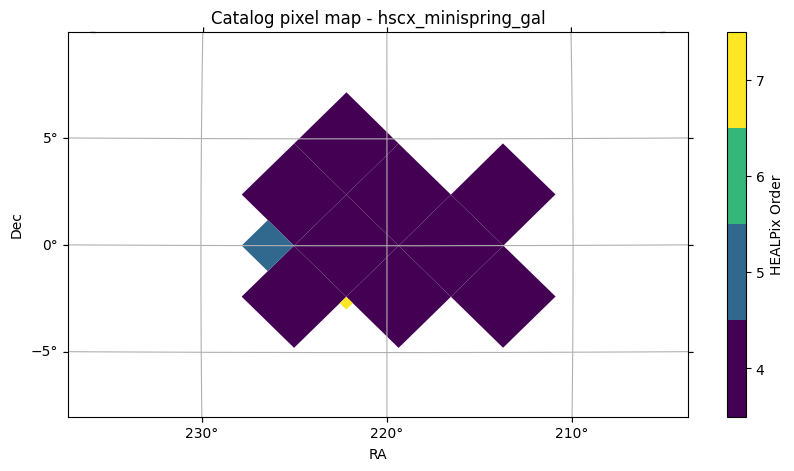

In [19]:
center = SkyCoord(220.5*u.deg, 1*u.deg)
sources.plot_pixels(center=center, fov=[30*u.deg, 20*u.deg]);

<div class="callout"> To trigger the lazy evaluation sequence use .compute() method. Only then, the data is read into memory, processed and returned as a dataframe. Ideally, compute() should be the last operation performed within a HATS/LSDB flow work.
</div>

In [46]:
df = sources.compute()

In [47]:
df

ra       dec
_healpix_29                              
576460752429056303   225.000881   0.00155
576460752930009651    224.99987  0.002324
...                         ...       ...
3170534136297676447  224.995777 -0.004141
3170534137404233000  224.999934 -0.002113

[8459347 rows x 2 columns]

In [48]:
del df

## 1. Create the pipeline and run! 
-----------

The main class is called SkyMaskPipe. After a pipeline is instantiated, you can add masks (a.k.a. maps) due to various effects. These masks are independent boolean (or bit-packed boolean) healsparse maps we call <span style="color:rgba(255,107,107,0.99);font-size:1.1em">stages</span>. Stages are stored within the class along with some metadata. Some typical stages are:
* <span class='st'>footmask</span> :: holds the footprint map created by pixelating discrete sources of a catalog
* <span class='st'>patchmask</span> :: holds the map created from HSC patches matching some criteria
* <span class='st'>propmask</span> :: mask created from the combination of multiple healsparse propery maps matching some criteria
* <span class='st'>circmask</span> :: mask created from a list of circular sources, usually stars 
* <span class='st'>boxmask</span> :: map created from a set of box regions 
* <span class='st'>ellipmask</span> :: map created from a set of elliptical regions

Once you have a few stages in the pipeline, their masks can be combined by <span class="met">combine()</span> into:
* <span class='st'>mask</span> :: mask generated from the logical combination of the maps above

In [20]:
mkp = SkyMaskPipe(order_out=15)
mkp.build_foot_mask(sources=lsdb.open_catalog(HATSCAT));
filt = "(gmag_psf_depth>26.2) and (rmag_psf_depth>25.9) and (imag_psf_depth>25.7)"
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, filt=filt);
mkp.build_circ_mask(data=STARS_REGIONS, fmt='parquet');
mkp.build_box_mask(data=BOX_STARS_REGIONS, fmt='parquet');
mkp.build_ellip_mask(data=ELLIP_REGIONS, fmt='ascii');

BUILDING FOOT MASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Order :: 13
--- Pixelating HATS catalog
--- Foot mask area                         : 69.35790724770318
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing example_data/hsc_aux/tracts_patches_minispring.parquet
    Order :: 13
    Patches with QA                       : 3708
    Patches with QA fulfilling conditions : 2003
    Surviving patch pixels                : 1062650
--- Patch mask area                           : 54.43575391135537
BUILDING CIRCLES MASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from example_data/hsc_aux/stars_iband.parquet
    Order :: 15 | pixelization_threads=4
    Circles to pixelate: 223015 in batches of 600000
        processing circles 0:223015 ...
--- Circles mask area                        : 12.277230882152068
BUILDING BOXES MASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating boxes from example_data/hsc_aux/starboxes_iband.parquet
 

<br>
<div class="callout"> Just type the instance name to display useful information like orders, valid pixels, area, etc.
</div>

In [9]:
mkp

footmask       : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1353948  area= 69.36 deg² pix_size=  25.8"
patchmask      : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1062650  area= 54.44 deg² pix_size=  25.8"
circmask       : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=3834656  area= 12.28 deg² pix_size=   6.4"
boxmask        : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=1737887  area=  5.56 deg² pix_size=   6.4"
ellipmask      : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=169105   area=  0.54 deg² pix_size=   6.4"

<br>
<div class="callout">Now combine into a "final" mask by intersecting footmask with patchmask and subtracting circles and boxes
(e.g. due to stars), and ellipses (e.g. due to large galaxies). If maps have different geometry such as
sparse order or coverage order, they will be reprojected on the fly to allow combination</div>

In [10]:
mkp.combine(positive=[('footmask','patchmask')], negative=['circmask','boxmask','ellipmask'], verbose=True);

[combine] aligning coverage for 'footmask' : c4 → c4
[combine] aligning coverage for 'patchmask' : c4 → c4
[combine] aligning coverage for 'circmask' : c4 → c4
[combine] aligning coverage for 'boxmask' : c4 → c4
[combine] aligning coverage for 'ellipmask' : c4 → c4
[combine] target=(o15, c4), work_order=13, r2=16
[combine:&] group of 2 stages: orders=[13, 13] -> work 13
[combine] done: order_out=15 (NSIDE=32768), order_cov=4 (NSIDE=16), valid_pix=14,312,202, area=45.823 deg², bit_packed=True


In [11]:
mkp  # note now there is a new "mask" stage

footmask       : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1353948  area= 69.36 deg² pix_size=  25.8"
patchmask      : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1062650  area= 54.44 deg² pix_size=  25.8"
circmask       : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=3834656  area= 12.28 deg² pix_size=   6.4"
boxmask        : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=1737887  area=  5.56 deg² pix_size=   6.4"
ellipmask      : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=169105   area=  0.54 deg² pix_size=   6.4"
mask           : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=14312202  area= 45.82 deg² pix_size=   6.4"

<br>

<div class="callout"><span class="met">combine()</span> can perform the union ( specified between braquets [] ) and the intersection ( specified between parenthesis() ) of any stage specified in the positive group. For example, the following would intersect footmask with patchmask, join the result with zonemask and subtract the three masks for circles, boxes and ellipses:</div>
<div class="callout"><center><span style="font-family: monospace;">mkp.combine(positive=[('footmask','patchmask'),'zonemask'], negative=['circmask','boxmask','ellipmask'])</span></div>

## 2. Generate randoms / Apply final mask to input catalog / Save pipeline to disk
---------

<div class="callout">Generate randoms over the <span class=st>mask</span> stage</div>

In [12]:
rands = mkp.makerans(stage='mask', nr=500_000)
rands[:5]

ra       dec
0  223.849815  3.384273
1  224.412113  3.497640
2  222.383993  2.386612
3  222.993922  2.386771
4  224.174180  1.908120

<div class="callout">Generate randoms over any stage</div>

In [9]:
rands_in_holes = mkp.makerans(stage='ellipmask', nr=100_000)
rands_in_holes[:5]

ra       dec
0  223.895960  2.523245
1  223.657243  2.227763
2  223.705357  2.220768
3  223.688228  2.103939
4  223.854504  2.115175

<div class="callout">Use <span class='met'>apply()</span> to return a catalog filtered by any mask stage</div>

In [10]:
import lsdb
cat = lsdb.read_hats(HATSCAT, columns=['ra','dec']).compute()
srcs_masked = mkp.apply(stage='mask', cat=cat, columns=['ra','dec'])

6014995 sources within mask


<br>
<div class="callout">Save the SkyMaskPipe object to disk. This will create a directory where each stage is saved in FITS format using bit-encoding compression, plus a JSON file holding various metadata</div>

In [11]:
mkp.write('./minispring_pipe', overwrite=True)

## 3. Explore some plots
-------------------

<div class="callout">The <span class='met'>plot()</span> method is suitable for very fast visualizations by plotting random (ra,dec) sources over the given stage</div>

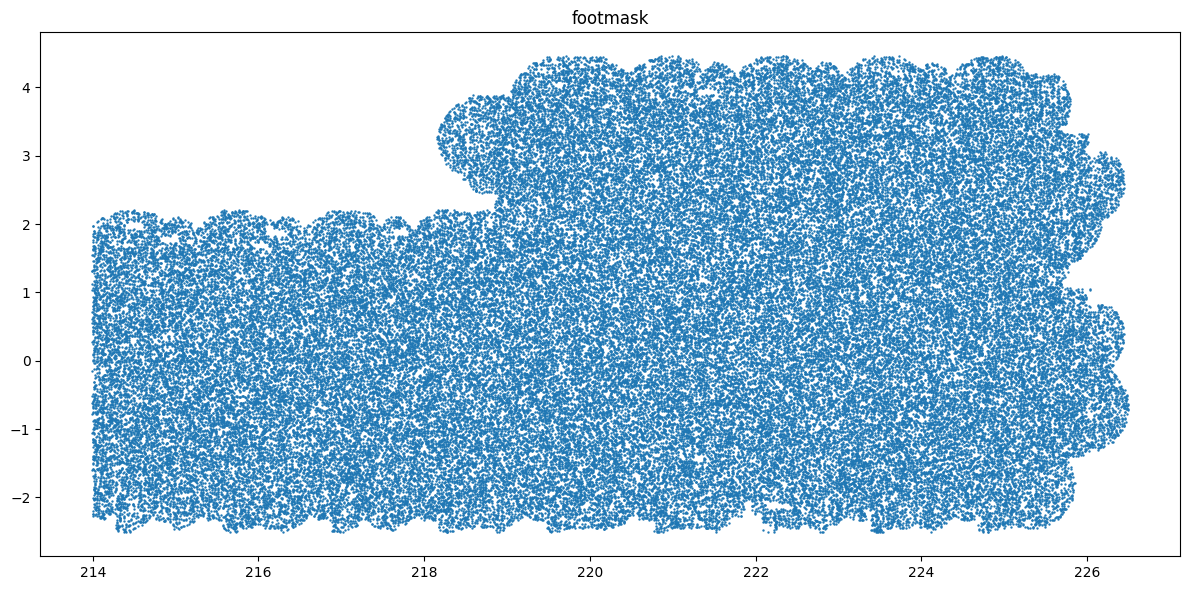

In [13]:
# Plot the footprint
mkp.plot(stage='footmask')

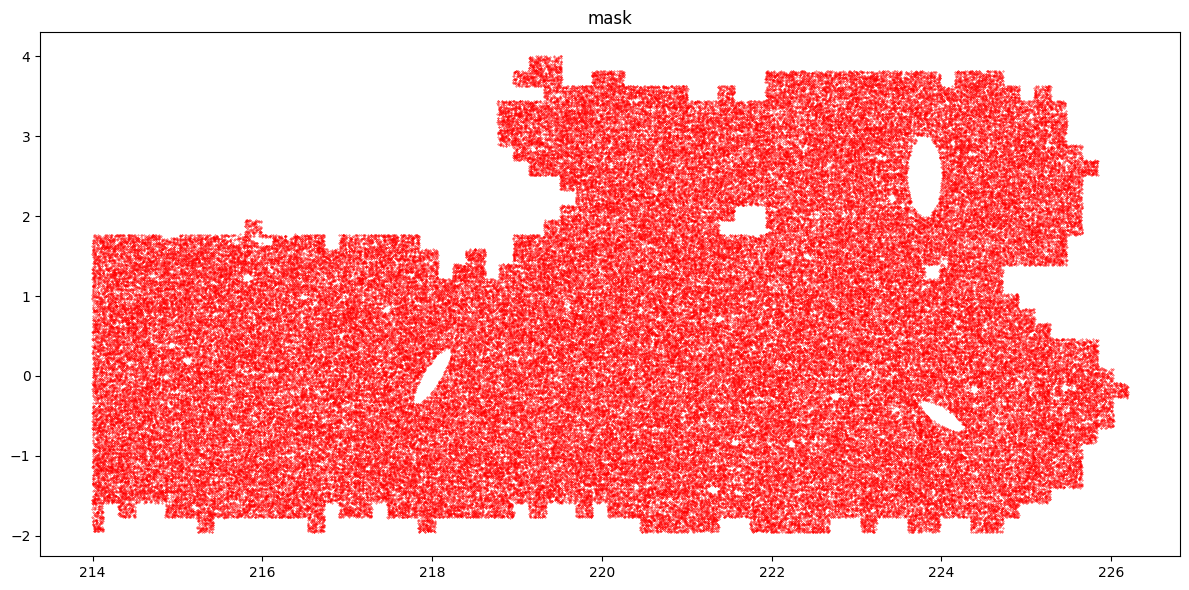

In [14]:
# Plot the final mask, 200k randoms
mkp.plot(stage='mask', nr=200_000, s=0.09, color='r')

<br>

<div class="callout">Plot a zoom of <span class='st'>mask</span>, including the circles and boxes associated to stars masked out</div>

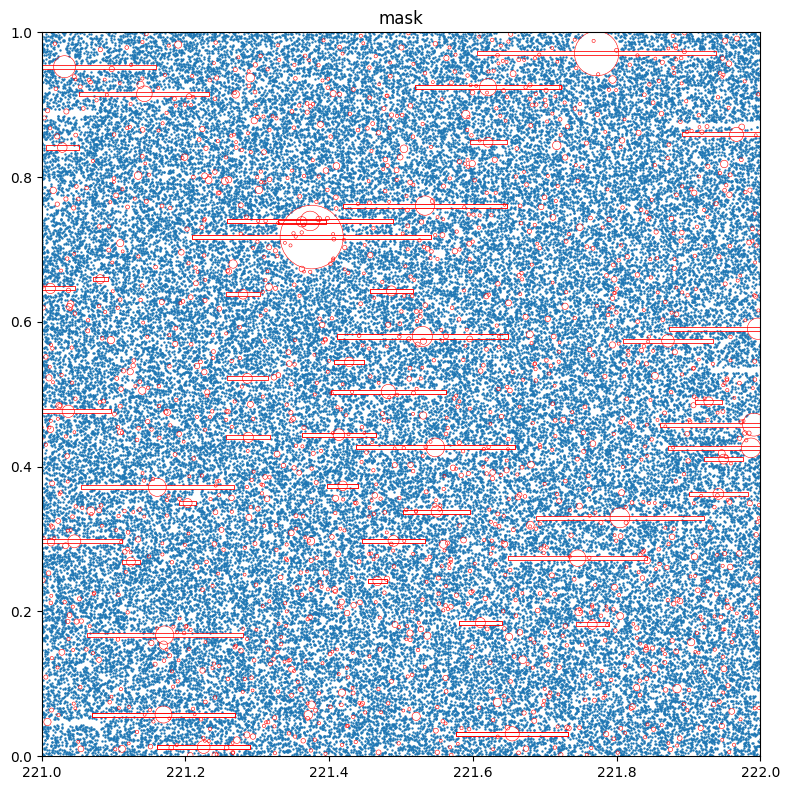

In [14]:
# Define two dictionaries with data files, format and column names
stars={'data':str(STARS_REGIONS), 'fmt':'parquet', 'columns':['ra','dec','radius']}
boxes={'data':str(BOX_STARS_REGIONS), 'fmt':'parquet', 'columns':['ra_c','dec_c','width','height']}
mkp.plot(stage='mask', nr=4_000_000, figsize=[8,8], clipra=[221,222], clipdec=[0,1], plot_circles=stars, plot_boxes=boxes)

<br>

<div class="callout">The <span class='met'>plot_moc()</span> method is adequate for accurrate visualizations in a WCS axes with suitable projections</div>

Retrieving pixels...
Found 1353948 pixels
Creating display moc from pixels...
MOC max_order is 13 --> degrading to 11...
Drawing plot...
Retrieving pixels...
Found 1062650 pixels
Creating display moc from pixels...
MOC max_order is 13 --> degrading to 11...
Drawing plot...


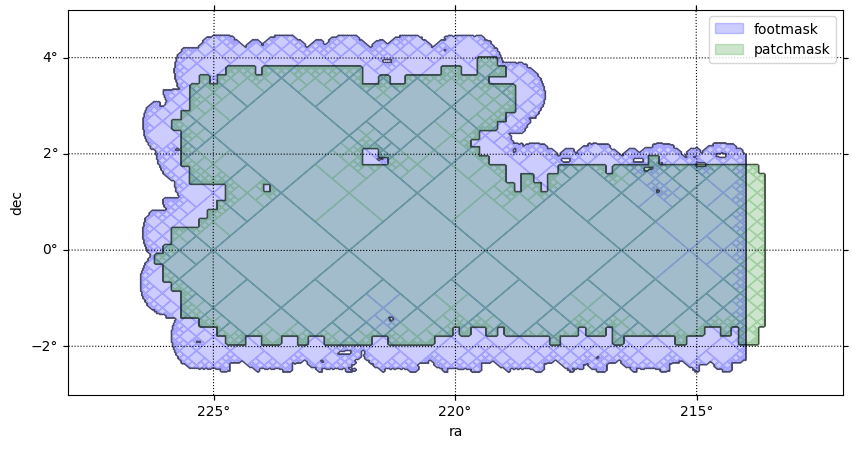

In [15]:
# Visualize stages by plotting their MOC in a WCS axes
center = SkyCoord(220*u.deg, 1*u.deg)   # specify the center of plot
fov    = 8 * u.deg                      # specify the field of view
fig, ax, wcs = mkp.plot_moc(stage='footmask', center=center, fov=fov, color='b', label='footmask')  # MOC of the foot mask
fig, ax, wcs = mkp.plot_moc(stage='patchmask', ax=ax, wcs=wcs, color='g', label='patchmask')        # MOC of the patch mask
plt.legend();

<br>

<div class="callout">Now plot a zoom of a MOC. When zooming by choosing a smaller FOV, millions of high order pixels can show up and slow down plotting and/or consume lots of memory. Use clipra/clipdec to specify a region of interest and avoid processing pixels outside the chosen display window</div>

Retrieving pixels inside clip box...
Found 504524 pixels
Creating display moc from pixels...
MOC max_order is 15 --> no degrading...
Drawing plot...


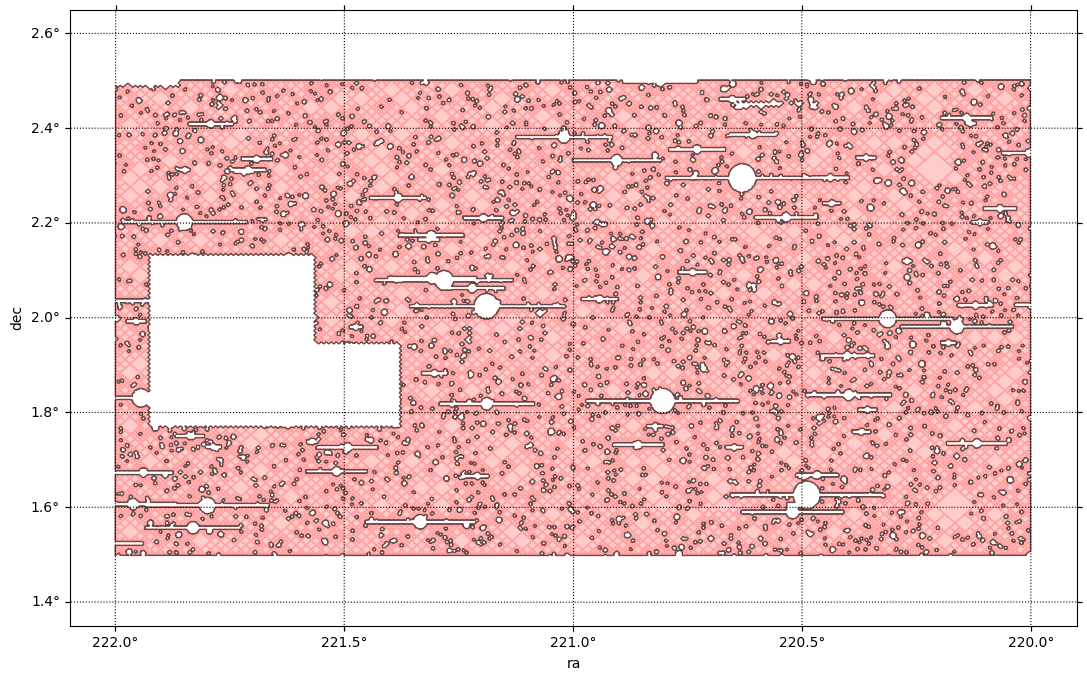

In [17]:
center = SkyCoord(221*u.deg, 2*u.deg)    # center of plot
fov    = [2.2*u.deg, 1.3*u.deg]          # field of view 
clipra = [220, 222]                      # ra limits for processing pixels
clipdec = [1.5, 2.5]                     # dec limits for processing pixels
fig, ax, wcs = mkp.plot_moc(stage='mask',  center=center, fov=fov,  color='r', clipra=clipra, clipdec=clipdec, figsize=[13,8])

<br>
<div class="callout">At some point it might be desirable to plot actual sources to check where they fall respecto to a mask. Plot another zoom and overlay a catalog sources, in this case the sources we already applied the mask before</div>

Retrieving pixels inside clip box...
Found 99104 pixels
Creating display moc from pixels...
MOC max_order is 15 --> no degrading...
Drawing plot...


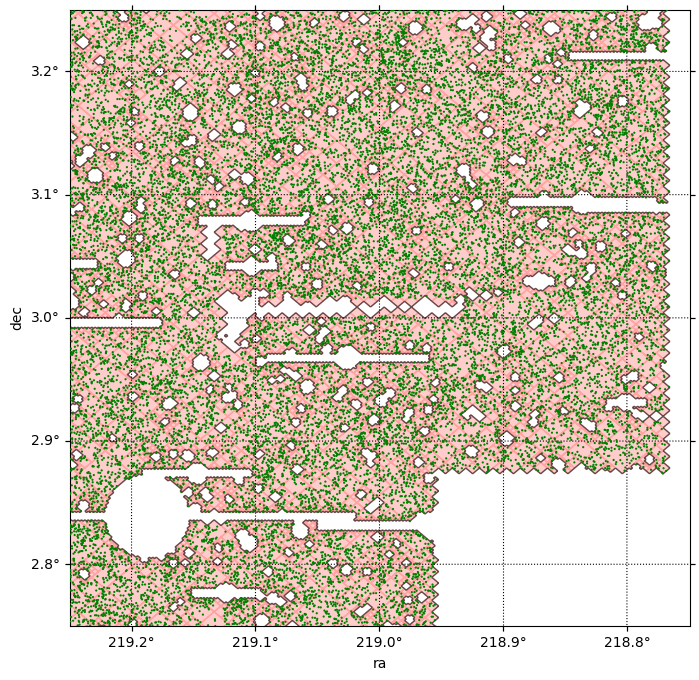

In [20]:
center = SkyCoord(219*u.deg, 3*u.deg)    # center of plot
fov    = [0.5*u.deg, 0.5*u.deg]          # field of view 
clipra = [218.5, 219.3]                  # ra limits for processing pixels
clipdec = [2.7, 3.5]                     # dec limits for processing pixels
fig, ax, wcs = mkp.plot_moc(stage='mask',  center=center, fov=fov,  color='r', alpha=0.2, clipra=clipra, clipdec=clipdec, figsize=[8,8])
fig, ax, wcs = mkp.plot_srcs(srcs_masked['ra'], srcs_masked['dec'], ax=ax, wcs=wcs, s=10, alpha=1, color='g', zorder=10)

## 4. Build methods: from geometry to masks

<div class="callout"><span class="sc">Skykatana</span> has methods to pixelate and generate masks from a variety of geometric shapes</div>

In [16]:
mkp = SkyMaskPipe(order_out=15)
mkp.build_foot_mask(sources=lsdb.open_catalog(HATSCAT));                      # from individual point sources
mkp.build_prop_mask(prop_maps=PROPMAP_FILE,thresholds=1.3,comparisons='lt');  # from healsparse property maps
mkp.build_circ_mask(data=STARS_REGIONS, fmt='parquet');                       # from circular regions
mkp.build_box_mask(data=BOX_STARS_REGIONS, fmt='parquet');                    # from box regions
mkp.build_ellip_mask(data=ELLIP_REGIONS, fmt='ascii');                        # from elliptical regions
mkp.build_poly_mask(data=USER_POLY_REGIONS, fmt='ascii');                     # from quadrangular sky polygons
mkp.build_zone_mask(data=USER_ZONE_REGIONS, fmt='ascii');                     # from zones delimited by ra-dec boundaries
filt = "(gmag_psf_depth>26.2) and (rmag_psf_depth>25.9) and (imag_psf_depth>25.7)"
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, filt=filt);        # from a sets of patches with custom filtering

BUILDING FOOT MASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Order :: 13
--- Pixelating HATS catalog
--- Foot mask area                         : 69.35790724770318
BUILDING PROPERTY MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing example_data/hsc_aux/sfd_ebv_piece.fits
--- Propertymap coverage order changed to 4
--- Propertymap sparse order changed to 15
--- Propertymap mask area                       : 113.86116591708016
BUILDING CIRCLES MASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from example_data/hsc_aux/stars_iband.parquet
    Order :: 15 | pixelization_threads=4
    Circles to pixelate: 223015 in batches of 600000
        processing circles 0:223015 ...
--- Circles mask area                        : 12.277230882152068
BUILDING BOXES MASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating boxes from example_data/hsc_aux/starboxes_iband.parquet
    Order :: 15
    done
--- Boxes mask area                           : 5.564107952862163
BUIL

<div class="callout">Each the these <span style='font-family: monospace; font-weight:bold;'>build_</span> methods store its calling arguments in dictionaries under <span style='font-family: monospace;font-weight:bold;'>_params</span>. In this way, all the metadata used to create masks is saved in the pipeline and kept for record. Use <span class='met'>stage_meta()</span> to quickly access the metadada associated with a stage.</div>

In [17]:
mkp.stage_meta('footmask')

{'nside_sparse': 8192,
 'nside_coverage': 16,
 'order_sparse': 13,
 'order_coverage': 4,
 'sources': PosixUPath('example_data/hscx_minispring_gal'),
 'columns': ('ra', 'dec'),
 'remove_isopixels': False,
 'erode_borders': False,
 'bit_packed': False,
 'pixels': np.int64(1353948),
 'area_deg2': np.float64(69.35790724770318)}

<div class='callout'>In the simple example above, the command is equivalent to <span class='icode'>mkp._params['footmask']</span>. Access all dictionaries with <span class='icode'>mkp._params</span></div>

<div class="callout">All <span style='font-family: monospace; font-weight:bold;'>build_</span> methods create a stage of a given name, e.g. <span class='st'>footmask</span>, <span class='st'>propmask</span>, <span class='st'>circmask</span>, etc. But you can add your own stages with any name or origin as long as they are valid healsparse boolean masks. See section about custom names below in this notebook</div>

<div class='note'>Note that while any name is valid for a stage, only stages ending with "mask" show up when printing, e.g cirrusmask, satellitemask, nebulamask</div>

## 5. Creating masks from property maps
----------

<div class="callout">While patches are geometric constructions specific to HSC, in general you can also restrict to areas of the sky meeting certain conditions if you have healsparse propery maps available</div>

<div class="callout">The map file below contains a small region of the dust extinction map of Schlegel, Finkbeiner & Davies in healsparse format. We will do an arbitrary cut to discard areas with very high extinction and intersect <span class='st'>footmask</span>, <span class='st'>patchmask</span> and <span class='st'>propmask</span></div>

In [23]:
mkp.build_prop_mask(prop_maps=PROPMAP_FILE,thresholds=1.3,comparisons='lt')
mkp.combine(positive=[('footmask','patchmask','propmask')]);

BUILDING PROPERTY MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing example_data/hsc_aux/sfd_ebv_piece.fits
--- Propertymap coverage order changed to 4
--- Propertymap sparse order changed to 15
--- Propertymap mask area                       : 113.86116591708016
[combine] aligning coverage for 'footmask' : c4 → c4
[combine] aligning coverage for 'patchmask' : c4 → c4
[combine] aligning coverage for 'propmask' : c4 → c4
[combine] target=(o15, c4), work_order=13, r2=16
[combine:&] group of 3 stages: orders=[13, 13, 15] -> work 13
[combine] done: order_out=15 (NSIDE=32768), order_cov=4 (NSIDE=16), valid_pix=14,497,392, area=46.416 deg², bit_packed=True


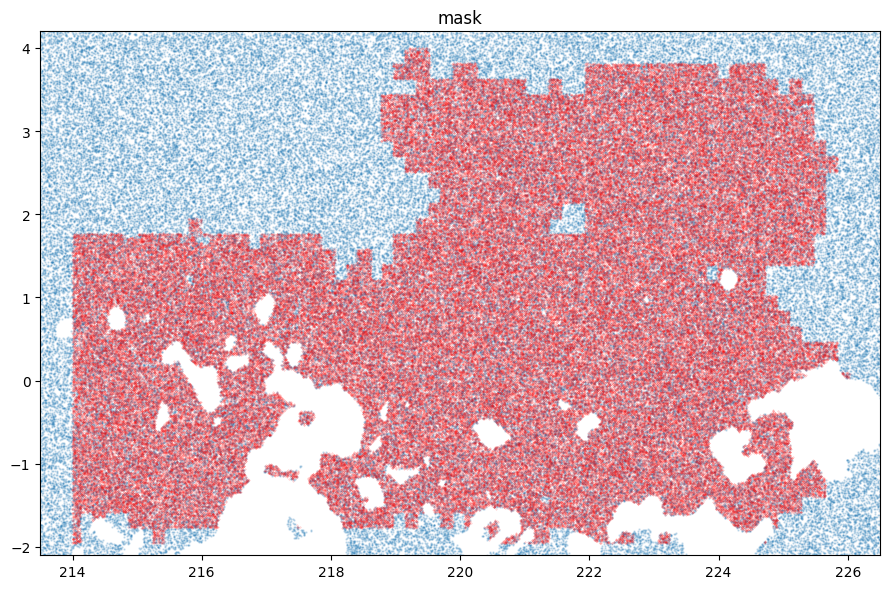

In [24]:
# Overlay the SFD extincion mask and the new combined final mask
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[9,6])
mkp.plot(stage='propmask', nr=200_000, alpha=0.2, clipra=[213.5, 226.5], clipdec=[-2.1,4.2], ax=ax)
mkp.plot(stage='mask', nr=200_000, s=0.09, color='r', alpha=0.3 , ax=ax)

<div class="callout">To apply multiple maps and thresholds, just specify them as lists. In this case we pick areas with extinction between 1.3 and 3.0 magnitudes in the SFD dust map.</div>

BUILDING PROPERTY MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing example_data/hsc_aux/sfd_ebv_piece.fits
--- Processing example_data/hsc_aux/sfd_ebv_piece.fits
--- Propertymap coverage order changed to 4
--- Propertymap sparse order changed to 15
--- Propertymap mask area                       : 10.606737365896201
Retrieving pixels...
Found 3312896 pixels
Creating display moc from pixels...
MOC max_order is 15 --> degrading to 11...
Drawing plot...


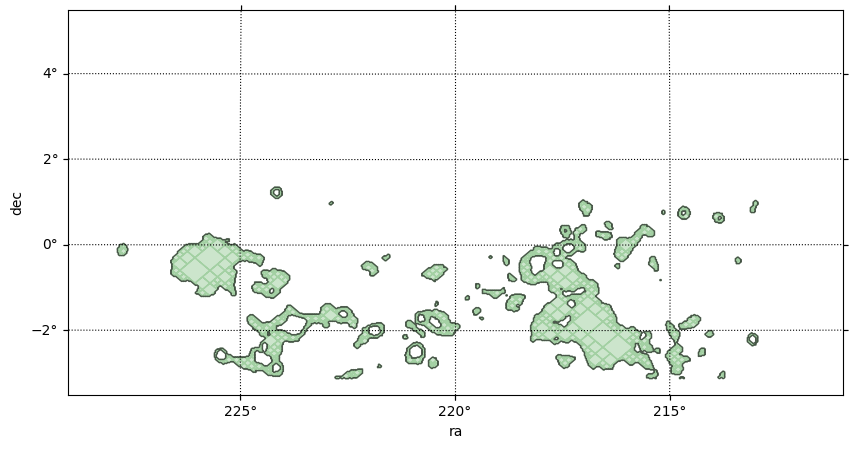

In [25]:
# create new stage called bad_mask, and plot
mkp.build_prop_mask(prop_maps=[PROPMAP_FILE,PROPMAP_FILE],thresholds=[1.3,3.0],comparisons=['gt','lt'], output_stage='bad_mask')
center = SkyCoord(220*u.deg, 1*u.deg)   # center of plot
fov    = 9 * u.deg                      # field of view
mkp.plot_moc(stage='bad_mask', center=center, fov=fov);

## 6. Creating masks from filtered patches
----------

<div class="callout">In the HSC-SSP survey, patches are characterized by properties like seeing or depth. Lets create a mask for the patches above a given minimum i-band depth</div>

In [26]:
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, filt='(imag_psf_depth>26.3)', output_stage='new_patchmask')
mkp.combine(positive=[('footmask','new_patchmask')], output_stage='new_mask');

BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing example_data/hsc_aux/tracts_patches_minispring.parquet
    Order :: 13
    Patches with QA                       : 3708
    Patches with QA fulfilling conditions : 1167
    Surviving patch pixels                : 633006
--- Patch mask area                           : 32.426630443148184
[combine] aligning coverage for 'footmask' : c4 → c4
[combine] aligning coverage for 'new_patchmask' : c4 → c4
[combine] target=(o15, c4), work_order=13, r2=16
[combine:&] group of 2 stages: orders=[13, 13] -> work 13
[combine] done: order_out=15 (NSIDE=32768), order_cov=4 (NSIDE=16), valid_pix=9,693,840, area=31.036 deg², bit_packed=True


<div class="callout">Rewrite the original patchmask, but without subtracting anything else</div>

In [27]:
mkp.combine(positive=[('footmask','patchmask')], verbose=False);

In [28]:
mkp

footmask       : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1353948  area= 69.36 deg² pix_size=  25.8"
patchmask      : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1062650  area= 54.44 deg² pix_size=  25.8"
propmask       : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=35563264  area=113.86 deg² pix_size=   6.4"
circmask       : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=3834656  area= 12.28 deg² pix_size=   6.4"
boxmask        : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=1737887  area=  5.56 deg² pix_size=   6.4"
ellipmask      : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=169105   area=  0.54 deg² pix_size=   6.4"
polymask       : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=76434    area=  0.24 deg² pix_size=   6.4"
zonemask       : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=941268   area=  3.01 deg² pix_size=   6.4"
mask           : (ord/nside)cov=4/16   (ord/nsi

Retrieving pixels...
Found 16427920 pixels
Creating display moc from pixels...
MOC max_order is 15 --> degrading to 12...
Drawing plot...
Retrieving pixels...
Found 9693840 pixels
Creating display moc from pixels...
MOC max_order is 15 --> degrading to 12...
Drawing plot...


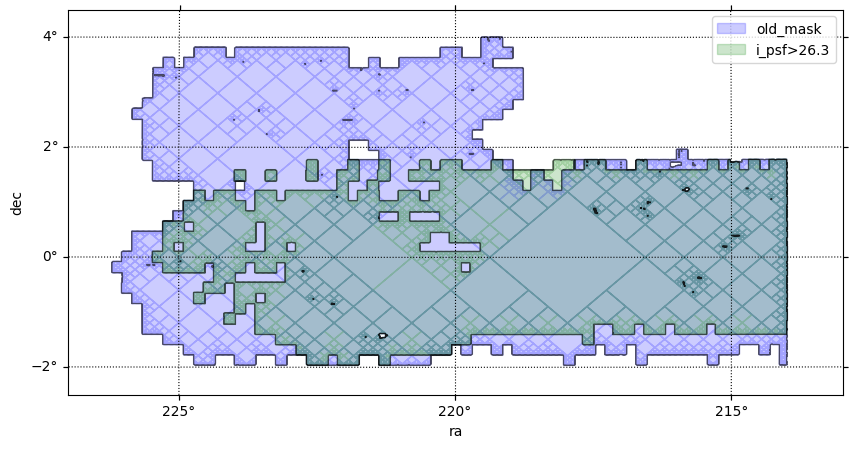

In [29]:
center = SkyCoord(220*u.deg, 1*u.deg)   # center of plot
fov    = 7 * u.deg                      # field of view
fig, ax, wcs = mkp.plot_moc(stage='mask', center=center, fov=fov, color='b', label='old_mask')
fig, ax, wcs = mkp.plot_moc(stage='new_mask', ax=ax, wcs=wcs, color='g', label='i_psf>26.3')
plt.legend();

## 7. Stages with custom names
----------

<div class="callout">All <span class='icode'>build_*</span> methods create a stage with a fixed name, e.g. <span class='st'>footmask</span>, <span class='st'>propmask</span>, <span class='st'>circmask</span>, etc. These are canonical names chosen to help structuring your pipleline, but <span class="sc">SkyKatana</span> is not rectricted in that aspect. You can add your own stages with any name (or origin) as long as they are valid healsparse boolean (or bit-packed boolean) masks. The <span class='icode'>build_*</span> methods support an <span class='icode'>output_stage</span> keyword to specify stages with custom names, and they will also store on each call the corresponding dictionary with calling parameters under <span class='icode'>_params</span>.</div>
<br>
<div class="callout">Lets use <span class='met'>build_circ_mask()</span> to create bogus masks due to two different star catalogs and store them with custom names (do not excute the cells below unless you supply the input files).</div>


In [ ]:
mkp.build_circ_mask(data='starcat1.parquet', fmt='parquet', output_stage = 'stars1_mask');
mkp.build_circ_mask(data='starcat2.parquet', fmt='parquet', output_stage = 'stars2_mask');

<br>
<div class="callout">Now create a bogus cirrus mask with plain mocpy and add it to the pipeline</div>

In [ ]:
import healsparse as hsp, numpy as np
from mocpy import MOC
from astropy.coordinates import SkyCoord
moc = MOC.from_zone(SkyCoord([[220, -5], [222, 0.3]], unit="deg"), max_depth=15)
cirrus = hsp.HealSparseMap.make_empty(2**4, 2**15, dtype=np.bool_)
pixels = moc.flatten().astype(np.int64)
cirrus.update_values_pix(pixels, True)
cirrusmask = cirrus.as_bit_packed_map()    #  <--- the mask

mkp.cirrusmask = cirrusmask   # <-- add to pipeline

<div class="callout">Then, you can work, combine and plot as with any other stage as normal</div>

In [ ]:
mkp.combine(positive=['footmask','patchmask','cirrusmask'], negative=['stars1_mask','stars2_mask','ellipmask']);

## 8. Creating footprints for large catalogs
----------

<div class="callout">Pixelizing large surveys such as Rubin can be time comsuming or even impossible due to the size of the catalogs. To accomodate such cases when the the data is too large to fit into memory or takes too long to process, you can distribute the task per partition (i.e. HATS pixels) among multiple workers of a Dask cluster. This is controlled with the flag <span class='icode'>mapping=True</span>.</div>

In [18]:
# First, create a dask cluster with 4 workers
from dask.distributed import Client
client = Client(n_workers=3, threads_per_worker=1, memory_limit="6GiB")

In [19]:
client

<Client: 'tcp://127.0.0.1:41675' processes=3 threads=3, memory=18.00 GiB>

In [20]:
mkp = SkyMaskPipe()
mkp.build_foot_mask(lsdb.open_catalog(HATSCAT), order_sparse=13, mapping=True)

BUILDING FOOT MASK >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    Order :: 13
--- Pixelating HATS catalog
    Partitions for mapping: 11     
--- Foot mask area                         : 69.35790724770318


HealSparseMap: nside_coverage = 16, nside_sparse = 8192, bool, 1353948 valid pixels

In [21]:
mkp

footmask       : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1353948  area= 69.36 deg² pix_size=  25.8"

In [22]:
client.close()